<a href="https://colab.research.google.com/github/MatteoRobbiati/notebooks/blob/main/QTI-QML-tutorial/QML_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QTI-TH Forum: a snapshot of Quantum Machine Learning

In [ ]:
# install qibo
!pip install qibo

In [ ]:
# import qibo's packages
import qibo
from qibo import gates, hamiltonians, derivative
from qibo.models import Circuit

# some useful python package
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.5)

# to interact with the operating system
import os

# numpy backend is enough for a 1-qubit model
qibo.set_backend('numpy')

### A variational quantum circuit

We are going to use a variational quantum circuit as Machine Learning model.
In order to do this, we will use the circuit's parameters as variational parameters during the train. 

We also need a way to embed some external data into the circuit.

In [ ]:
nqubits = 1
layers = 2

c = Circuit(nqubits)
for q in range(nqubits):
  # an Hadamard gate at the beginning
  c.add(gates.H(q=q))
  # and a sequence of rotation layers as model
  for l in range(layers):
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RZ(q=q, theta=0))
  c.add(gates.M(0))


This specific sequence of gates is important if we want to implement the following ansatz:

<center><img src="https://github.com/MatteoRobbiati/notebooks/blob/main/QTI-QML-tutorial/images/re-uploading.png?raw=true" alt="drawing" width="800"/></center>

#### A way for performing the re-uploading of $x$ into the circuit

In [ ]:
def inject_parameters(circuit, parameters, x):
  """Prototype function for the embedding of x."""
  params = []
  index = 0
  
  for q in range(nqubits):
    for l in range(layers):
      # embed the first feature
      params.append(parameters[index] * x[0])
      params.append(parameters[index + 1])
      # embed the second feature
      params.append(parameters[index + 2])
      index += 3

  circuit.set_parameters(params)
  return circuit

In [421]:
# setting new parameters
nparams = len(c.get_parameters())
initial_parameters = np.random.randn(nparams) * 5

### We need a predictor $\langle \hat{O} \rangle$!

Applying the circuit $C(x, \theta)$ to the initial state $| 0 \rangle$, we get the final state of the qubit $|q_f\rangle$. In this example, we decide to use as predictor of $y$ the expected value of a non-interacting Pauli Z observable.

In [422]:
# define an hamiltonian
h = hamiltonians.Z(nqubits)

# a dummy value for x
x = [0.2]

# set them into the circuit together with an x
c = inject_parameters(c, initial_parameters, x)

# evaluating E[O]
h.expectation(c.execute(nshots=1000).state())

0.10371305990689966

## Let's put it all together in a variational quantum regressor

In [431]:
class vqregressor:

  def __init__(self, data, labels, layers, nqubits=1):
    """Class constructor."""
    # some general features of the QML model
    self.nqubits = nqubits
    self.layers = layers
    self.data = data
    self.labels = labels

    # initialize the circuit and extract the number of parameters
    self.circuit = self.ansatz(nqubits, layers)
    print(self.circuit.draw())

    # get the number of parameters
    self.nparams = len(self.circuit.get_parameters())
    # set the initial value of the variational parameters
    self.params = np.random.randn(self.nparams)
    # scaling factor for custom parameter shift rule
    self.scale_factors = np.ones(self.nparams)

    # define the observable
    self.h = hamiltonians.Z(nqubits)

# ---------------------------- ANSATZ ------------------------------------------

  def ansatz(self, nqubits, layers):
    """Here we implement the variational model ansatz."""
    c = Circuit(nqubits)
    for q in range(nqubits):
      c.add(gates.H(q=q))
      for l in range(layers):
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    c.add(gates.M(0))

    return c

# --------------------------- RE-UPLOADING -------------------------------------

  def inject_data(self, x):
    """Here we combine x and params in order to perform re-uploading."""
    params = []
    index = 0
    
    for q in range(self.nqubits):
      for l in range(self.layers):
        # embed X
        params.append(self.params[index] * x)
        params.append(self.params[index + 1])
        params.append(self.params[index + 2])
        # update scale factors 
        # equal to x only when x is involved
        self.scale_factors[index] = x
        # we have three parameters per layer
        index += 3

    # update circuit's parameters
    self.circuit.set_parameters(params)


# ------------------------------- PREDICTIONS ----------------------------------

  def one_prediction(self, x):
    """This function calculates one prediction with fixed x."""
    self.inject_data(x)

    return self.h.expectation(self.circuit.execute().state())


  def predict_sample(self):
    """This function returns all predictions."""
    predictions = []
    for x in self.data:
      predictions.append(self.one_prediction(x))

    return predictions


# ------------------------ PERFORMING GRADIENT DESCENT -------------------------


  def circuit_derivative(self):
    """Derivatives of the expected value of the target observable with respect 
    to the variational parameters of the circuit are performed via parameter-shift
    rule (PSR)."""
    dcirc = np.zeros(self.nparams)   
    
    for par in range(self.nparams):
      # read qibo documentation for more information about this PSR implementation
      dcirc[par] = qibo.derivative.parameter_shift(
          circuit = self.circuit, 
          hamiltonian = self.h, 
          parameter_index = par, 
          scale_factor = self.scale_factors[par]
          )
    
    return dcirc


  def evaluate_loss_gradients(self):
    """This function calculates the derivative of the loss function with respect
    to the variational parameters of the model."""

    # we need the derivative of the loss
    # nparams-long vector
    dloss = np.zeros(self.nparams)
    # we also keep track of the loss value
    loss = 0

    # cycle on all the sample
    for x, y in zip(self.data, self.labels):
      # calculate prediction
      prediction = self.one_prediction(x)
      # derivative of E[O] with respect all thetas
      dcirc = self.circuit_derivative()
      # calculate loss and dloss
      mse = (prediction - y)
      loss += mse**2
      dloss += 2 * mse * dcirc

    return dloss, loss/len(self.data)
  

  def gradient_descent(self, learning_rate, epochs):
    """This function performs a full gradient descent strategy."""

    # we create a folder
    os.system("mkdir ./live-plotting")
    # ww clean it if already exists
    os.system("rm ./live-plotting/*")

    # we want to keep track of the loss function
    loss_history = []

    # the gradient descent strategy
    for epoch in range(epochs):
      dloss, loss = self.evaluate_loss_gradients()
      loss_history.append(loss)
      self.params -= learning_rate * dloss
      print(f'Loss at epoch: {epoch + 1} ', loss)

      self.show_predictions(f'Epoch {epoch +1}', save=True)
    
    return loss_history


# ---------------------- PLOTTING FUNCTION -------------------------------------

  def show_predictions(self, title, save=False):
    """This function shows the obtained results through a scatter plot."""

    # calculate prediction
    predictions = self.predict_sample()

    # draw the results
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(self.data, self.labels, color='orange', alpha=0.6, label='Original', s=70, marker='o')
    plt.scatter(self.data, predictions, color='purple', alpha=0.6, label='Predictions', s=70, marker='o')

    plt.legend()

    # we save all the images during the training in order to see the evolution
    if save:
      plt.savefig(f'./live-plotting/'+str(title)+'.png')
      plt.close()

    plt.show()

### Generate a sample

We are going to fit a very simple function:

$$ y = \sin(2x).$$

In [436]:
ndata = 30
# random data
data = np.random.uniform(-1, 1, ndata)
# labeling them
labels = np.sin(2*data)

In [437]:
# initialize the QML algorithm
VQR = vqregressor(layers=2, data=data, labels=labels)

q0: ─H─RY─RY─RZ─RY─RY─RZ─M─


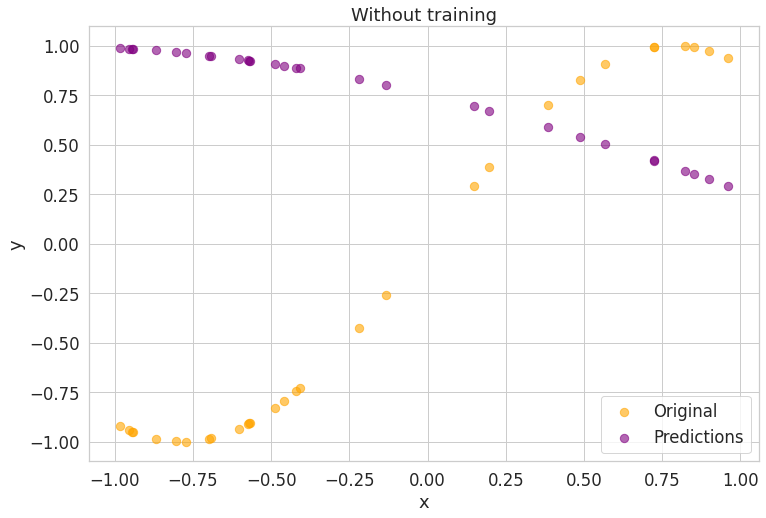

In [438]:
# show initial (WRONG) predictions
VQR.show_predictions('Without training')

In [439]:
# set the training hyper-parameters
epochs = 50
learning_rate = 1e-1

# perform the training
history = VQR.gradient_descent(learning_rate=1e-2, epochs=epochs)

Loss at epoch: 1  2.136286081355609
Loss at epoch: 2  1.5007361378699906
Loss at epoch: 3  0.27456863711177826
Loss at epoch: 4  0.11420596665272702
Loss at epoch: 5  0.06463170401710759
Loss at epoch: 6  0.042883287298741274
Loss at epoch: 7  0.031122660188428186
Loss at epoch: 8  0.02390144527820342
Loss at epoch: 9  0.01907272919969204
Loss at epoch: 10  0.015641158155803723
Loss at epoch: 11  0.0130891709808357
Loss at epoch: 12  0.011123708441808293
Loss at epoch: 13  0.009567536340320702
Loss at epoch: 14  0.008307695097898391
Loss at epoch: 15  0.007269040566470261
Loss at epoch: 16  0.006399770255372572
Loss at epoch: 17  0.005663078556130996
Loss at epoch: 18  0.0050321284685940606
Loss at epoch: 19  0.004486905610762132
Loss at epoch: 20  0.004012185016481113
Loss at epoch: 21  0.0035961794603487796
Loss at epoch: 22  0.003229618282204996
Loss at epoch: 23  0.0029051056587733964
Loss at epoch: 24  0.0026166647187043355
Loss at epoch: 25  0.002359407957980113
Loss at epoch: 26

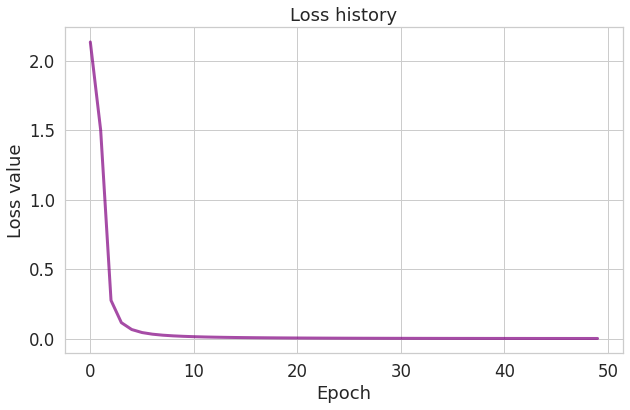

In [444]:
# showing loss history
plt.figure(figsize=(10,6))
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.plot(history, lw=3, c='purple', alpha=0.7)
plt.show()

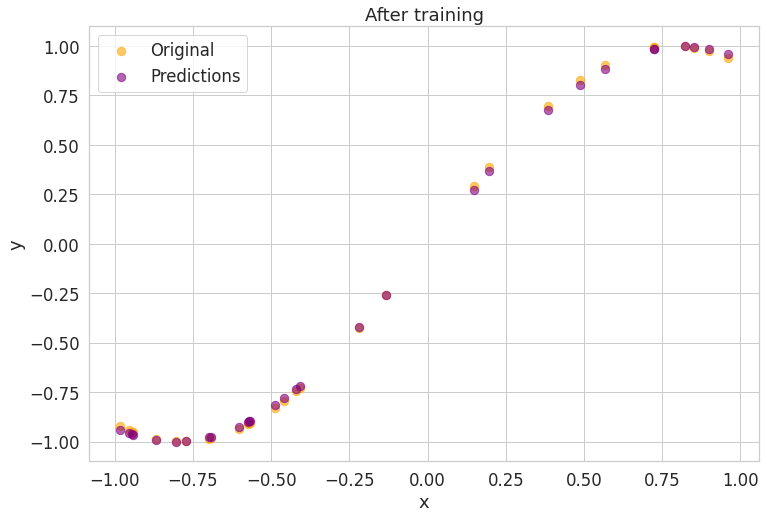

In [445]:
# final results
VQR.show_predictions('After training')

### Let's visualize the training with a gif

In [ ]:
from PIL import Image

images = []

for epoch in range(epochs):
  images.append(Image.open("./live-plotting/Epoch " + str(epoch + 1) + ".png"))

first_image = images[0]
first_image.save("./training.gif", format="GIF", append_images=images,
               save_all=True, duration=100, loop=0)